we invert the usual way of matching genes and variants for cis qtl mapping. rather than taking all variants within 1MB of a gene, we take all genes within 1MB of an LD block of variants


LD blocks from: https://www.biorxiv.org/content/10.1101/2022.03.04.483057v2 (https://github.com/jmacdon/LDblocks_GRCh38/blob/master/data/pyrho_EUR_LD_blocks.bed)

In [42]:
import pandas as pd
import numpy as np
import pyranges as pr
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
ld_blocks = pd.read_table("/home/klawren/oak/gtex/data/other_references/pyrho_EUR_LD_blocks.bed")

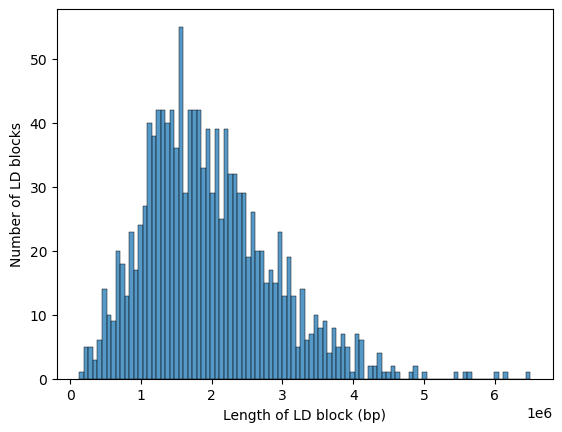

In [36]:
ld_blocks['length'] = ld_blocks['end'] - ld_blocks['start']
ax = sns.histplot(ld_blocks['length'], bins=100)
ax.set_xlabel('Length of LD block (bp)')
ax.set_ylabel('Number of LD blocks')
plt.show()

In [8]:
gencode_v47_path = "/home/klawren/oak/gtex/data/realign_references/gencode.v47.annotation.gtf"
gencode_v47 = pr.read_gtf(gencode_v47_path)
gencode_v47_df = gencode_v47.as_df()
gencode_v47_df = gencode_v47_df[~(gencode_v47_df['Chromosome'] == 'chrM')]

In [9]:
gencode_v47_genes_path = "/home/klawren/oak/gtex/data/realign_references/gencode.v47.genes.gtf"
gencode_v47_genes = pr.read_gtf(gencode_v47_genes_path)
gencode_v47_genes_df = gencode_v47_genes.as_df()
gencode_v47_genes_df = gencode_v47_genes_df[~(gencode_v47_genes_df['Chromosome'] == 'chrM')]

In [59]:
# Get the genes we can test for eqtls
tested_gencode = gencode_v47_df[(gencode_v47_df['gene_id'].isin(gencode_v47_genes_df['gene_id'])) & (gencode_v47_df['Feature'] == 'gene')]

# Not all genes are expressed in all tissues, so check for a sample tissue
tissue_id = 'Adipose_Subcutaneous'
sample_tissue_expression = pd.read_table(f"/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_eQTL_expression_matrices/{tissue_id}.v11.normalized_expression.bed.gz")
sample_tissue_genes = tested_gencode[tested_gencode['gene_id'].isin(sample_tissue_expression['gene_id'])]

In [54]:
gene_ids = []
num_genes = []
num_genes_sample_tissue = []
gene_min_start = []
gene_max_end = []
for idx, block in ld_blocks.iterrows():
    # Get all genes in tested_gencode within 1MB of the LD block start/end and on the same chromosome
    nearby_genes = tested_gencode[
        (tested_gencode['Chromosome'] == block['chr']) &
        (tested_gencode['Start'] <= block['end'] + 1e6) &
        (tested_gencode['End'] >= block['start'] - 1e6)]
    # Record the gene ids and maximum window
    gene_ids.append(nearby_genes['gene_id'].unique())
    num_genes.append(nearby_genes['gene_id'].nunique())
    num_genes_sample_tissue.append(nearby_genes[nearby_genes['gene_id'].isin(sample_tissue_genes['gene_id'])].shape[0])
    gene_min_start.append(nearby_genes['Start'].min())
    gene_max_end.append(nearby_genes['End'].max())

ld_blocks['gene_ids'] = gene_ids
ld_blocks['num_genes'] = num_genes
ld_blocks['num_genes_sample_tissue'] = num_genes_sample_tissue
ld_blocks['gene_min_start'] = gene_min_start
ld_blocks['gene_max_end'] = gene_max_end

ld_blocks.head()


,chr,start,end,length,gene_ids,num_genes,gene_min_start,gene_max_end,num_genes_sample_tissue
0,chr1,16103,1170341,1154238,"[ENSG00000290825.2, ENSG00000223972.6, ENSG000...",167,11120,2185395,106
1,chr1,1170341,1730405,560064,"[ENSG00000308415.1, ENSG00000308625.1, ENSG000...",182,89294,2801693,127
2,chr1,1730405,3355587,1625182,"[ENSG00000229905.1, ENSG00000237491.11, ENSG00...",208,586944,4319668,134
3,chr1,3355587,4320284,964697,"[ENSG00000295371.1, ENSG00000157916.20, ENSG00...",96,2321252,5307394,37
4,chr1,4320284,5649773,1329489,"[ENSG00000142611.17, ENSG00000130762.15, ENSG0...",104,3069167,6701924,44


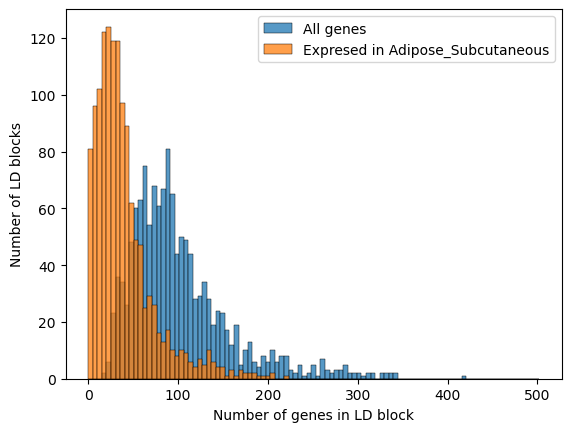

In [61]:
ax = sns.histplot(ld_blocks['num_genes'], bins=np.arange(0, ld_blocks['num_genes'].max(), ld_blocks['num_genes'].max()/100), label=f'All genes')
ax = sns.histplot(ld_blocks['num_genes_sample_tissue'], bins=np.arange(0, ld_blocks['num_genes'].max(), ld_blocks['num_genes'].max()/100), label=f'Expresed in {tissue_id}')

ax.set_xlabel('Number of genes in LD block')
ax.set_ylabel('Number of LD blocks')
ax.legend()
plt.show()

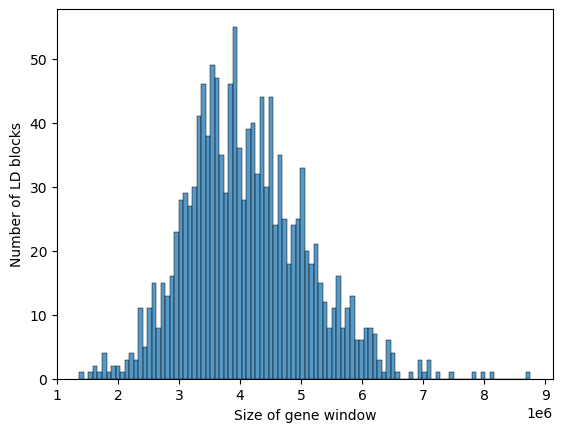

In [66]:
ld_blocks['var_window'] = ld_blocks['gene_max_end'] - ld_blocks['gene_min_start']

ax = sns.histplot(ld_blocks['var_window'], bins=100)
ax.set_xlabel('Size of gene window')
ax.set_ylabel('Number of LD blocks')
plt.show()

In [65]:
# write out the gene groups
ld_blocks[['chr', 'start', 'end', 'length', 'gene_ids', 'num_genes',
       'gene_min_start', 'gene_max_end']].to_csv('/home/klawren/oak/gtex/data/other_references/pyrho_EUR_LD_blocks.gene_groups.txt', sep='\t', index=False)